In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import sys
import collections
import cv2
import os
import math
import random
import pickle
import copy
import numpy as np
sys.path.append("C:\\GitHub\\MeronymNet-PyTorch\\src")

C:\Users\susha\anaconda3\envs\meronymnet\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\susha\anaconda3\envs\meronymnet\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\susha\anaconda3\envs\meronymnet\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import DataLoader
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

In [5]:
import matplotlib.pyplot as plt

In [ ]:
 python scripts/launch_gradio_app.py  \--config_file configs/COCO-stuff_256x256/LayoutDiffusion_large.yaml \sample.pretrained_model_path=./pretrained_models/COCO-stuff_256x256_LayoutDiffusion_large_ema_1150000.pt

In [ ]:
python -m torch.distributed.launch \ --nproc_per_node 1 \ scripts/image_train_for_layout.py \ --config_file ./configs/COCO-stuff_256x256/LayoutDiffusion_large.yaml

In [6]:
colors = [(1, 0, 0),
          (0.737, 0.561, 0.561),
          (0.255, 0.412, 0.882),
          (0.545, 0.271, 0.0745),
          (0.98, 0.502, 0.447),
          (0.98, 0.643, 0.376),
          (0.18, 0.545, 0.341),
          (0.502, 0, 0.502),
          (0.627, 0.322, 0.176),
          (0.753, 0.753, 0.753),
          (0.529, 0.808, 0.922),
          (0.416, 0.353, 0.804),
          (0.439, 0.502, 0.565),
          (0.784, 0.302, 0.565),
          (0.867, 0.627, 0.867),
          (0, 1, 0.498),
          (0.275, 0.51, 0.706),
          (0.824, 0.706, 0.549),
          (0, 0.502, 0.502),
          (0.847, 0.749, 0.847),
          (1, 0.388, 0.278),
          (0.251, 0.878, 0.816),
          (0.933, 0.51, 0.933),
          (0.961, 0.871, 0.702)]
colors = (np.asarray(colors)*255)
canvas_size = 660

def plot_bbx(bbx):
    bbx = bbx*canvas_size
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    for i, coord in enumerate(bbx):
        x_minp, y_minp,x_maxp , y_maxp = coord[:4]
        if [x_minp, y_minp, x_maxp, y_maxp]!=[0,0,0,0]:
            cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[i], 6)
    return canvas

def plot_obj_bbx(bbx):
    bbx = bbx*canvas_size
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    x_minp, y_minp,x_maxp , y_maxp = bbx
    cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[0], 6)
    return canvas

# def plot_bbx(bbx):
#     bbx = bbx*canvas_size
#     canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
#     for i, coord in enumerate(bbx):
#         x, y, w ,h = coord
#         if [x, y, w ,h]!=[0,0,0,0]:
#             cv2.rectangle(canvas, (int(x), int(y)), (int(x + w) , int(y + h) ), colors[i], 6)
#     return canvas


In [7]:
label_to_color ={0: (1,1,1),
 1: (1, 0, 0),
 2: (0.737, 0.561, 0.561),
 3: (0.255, 0.412, 0.882),
 4: (0.545, 0.271, 0.0745),
 5: (0.98, 0.502, 0.447),
 6: (0.98, 0.643, 0.376),
 7: (0.18, 0.545, 0.341),
 8: (0.502, 0, 0.502),
 9: (0.627, 0.322, 0.176),
 10:(0.753, 0.753, 0.753),
 11:(0.529, 0.808, 0.922),
 12:(0.416, 0.353, 0.804),
 13:(0.439, 0.502, 0.565),
 14:(0.784, 0.302, 0.565),
 15:(0.867, 0.627, 0.867),
 16:(0, 1, 0.498),
 17:(0.275, 0.51, 0.706),
 18:(0.824, 0.706, 0.549),
 19:(0, 0.502, 0.502),
 20:(0.847, 0.749, 0.847),
 21:(1, 0.388, 0.278),
 22:(0.251, 0.878, 0.816),
 23:(0.933, 0.51, 0.933),
 24:(0.961, 0.871, 0.702)}


def arrangement(a, b, object_name):
    if object_name=='cow' or object_name=='sheep':
        p = [10, 11, 13, 12, 14, 15, 8, 9, 0, 7, 3, 4, 5, 6, 1, 2]
    elif object_name=='bird':
        p = [13, 14, 15, 4, 12, 8, 9, 10, 11, 5, 6, 7, 0, 1, 2, 3]
    elif object_name=='person':
        p = [10, 11, 13, 12, 15, 14, 9, 0, 7, 8, 5, 6, 1, 2, 3, 4]
    elif object_name=='cat':
        p = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5]
    elif object_name=='dog':
        p = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5]
    elif object_name=='horse':
        p = [10, 11, 13, 12, 14, 15, 8, 9, 0, 7, 3, 4, 5, 6, 1, 2]
    else:
      print("error")
    return a[p], b[p], p

def label_2_image(img):
  rgb_img = np.zeros((img.shape[0],img.shape[1], 3)) 
  for key in label_to_color.keys():
      rgb_img[img == key] = label_to_color[key]
  return rgb_img

In [8]:
def mask_to_canvas(masks, bbx, obj_class):
    max_num_nodes=16
    canvas_size=550
    class_dict = {0:'cow',1:'sheep',2:'bird',3:'person',4:'cat',5:'dog',6:'horse'}
    obj = class_dict[np.argmax(obj_class)]
    canvas = np.zeros((canvas_size, canvas_size), dtype= 'float32')
    #print(bbx.shape)
    bb_in, mmx, mapping = arrangement(bbx, masks, class_dict[np.argmax(obj_class)])
    #print(bb_in.shape)
    for i in range(max_num_nodes):
        index = 0
        if not np.all(bb_in[i] == 0):
            index = mapping[i]
            #print(bb_in[i].shape)
            _, x_min, y_min, x_max, y_max = np.round(bb_in[i]*canvas_size)           
            if(x_min > x_max):
                x_max, x_min = x_min, x_max
            if(y_min > y_max):
                y_max, y_min = y_min, y_max
            if x_max-x_min >=1 and y_max-y_min>=1:
                x, y = int(x_max-x_min), int(y_max-y_min)
                gen_mask = np.zeros((64, 64))
                gen_mask[np.where(np.squeeze(mmx[i])>=0.45)] = (i+1)
                canvas[int(y_min):int(y_max), int(x_min):int(x_max)] = np.maximum(canvas[int(y_min):int(y_max), int(x_min):int(x_max)],
                                                                                  cv2.resize(gen_mask, (x, y)))

    sza = 10
    plt.figure(num=None, figsize=(sza, sza))
    plt.axis('off')
    plt.imshow(label_2_image(canvas))
    plt.show()
    #plt.savefig('D:/meronym_data/runs/mask_generation_model_tf2_reconstruction/lr00001/maskResults/'+obj+'/'+str(img_idx)+ '_'+prefix+'.png')
    plt.close()

In [9]:
def mask_to_canvas(masks, bbx, obj_class):
    max_num_nodes=16
    canvas_size=550
    class_dict = {0:'cow',1:'sheep',2:'bird',3:'person',4:'cat',5:'dog',6:'horse'}
    obj = class_dict[np.argmax(obj_class)]
    canvas = np.zeros((canvas_size, canvas_size), dtype= 'float32')
    #print(bbx.shape)
    bb_in, mmx, mapping = arrangement(bbx, masks, class_dict[np.argmax(obj_class)])
    #print(bb_in.shape)
    for i in range(max_num_nodes):
        index = 0
        if not np.all(bb_in[i] == 0):
            index = mapping[i]
            #print(bb_in[i].shape)
            _, x_min, y_min, x_max, y_max = np.round(bb_in[i]*canvas_size)           
            if(x_min > x_max):
                x_max, x_min = x_min, x_max
            if(y_min > y_max):
                y_max, y_min = y_min, y_max
            if x_max-x_min >=1 and y_max-y_min>=1:
                x, y = int(x_max-x_min), int(y_max-y_min)
                gen_mask = np.zeros((64, 64))
                gen_mask[np.where(np.squeeze(mmx[i])>=0.45)] = (i+1)
                canvas[int(y_min):int(y_max), int(x_min):int(x_max)] = np.maximum(canvas[int(y_min):int(y_max), int(x_min):int(x_max)],
                                                                                  cv2.resize(gen_mask, (x, y)))

    sza = 10
    plt.figure(num=None, figsize=(sza, sza))
    plt.axis('off')
    plt.imshow(label_2_image(canvas))
    plt.show()
    #plt.savefig('D:/meronym_data/runs/mask_generation_model_tf2_reconstruction/lr00001/maskResults/'+obj+'/'+str(img_idx)+ '_'+prefix+'.png')
    plt.close()

In [10]:
def inference_obj(decoder, node_data):

    decoder.cuda()
    z_latent = torch.normal(torch.zeros([batch_size,latent_dims])).cuda()
    nodes = torch.reshape(nodes,(batch_size,decoder.num_nodes))
    obj_class = torch.reshape(obj_class,(batch_size, decoder.class_size))
    conditioned_z = torch.cat([nodes, z_latent],dim=-1)
    conditioned_z = torch.cat([obj_class, conditioned_z],dim=-1)
    
    op = decoder(conditioned_z)
        
    return op[0], op[1], z_latent


def inference(decoder, nodes, obj_class, latent_dims, batch_size):

    decoder.cuda()
    z_latent = torch.normal(torch.zeros([batch_size,latent_dims])).cuda()
    nodes = torch.reshape(nodes,(batch_size,decoder.num_nodes))
    obj_class = torch.reshape(obj_class,(batch_size, decoder.class_size))
    conditioned_z = torch.cat([nodes, z_latent],dim=-1)
    conditioned_z = torch.cat([obj_class, conditioned_z],dim=-1)
    
    op = decoder(conditioned_z)
        
    return op[0], op[1], z_latent

In [40]:
obj_data_postfix = '_obj_boundary_sqr'
part_data_post_fix = '_scaled_sqr'
file_postfix = '_combined_mask_data'
outfile = 'C:/GitHub/meronymnet/data_np_16/X_train'+part_data_post_fix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/X_train'+obj_data_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_obj_train = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/class_v'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    class_v = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/adj_train'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    adj_train = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/masks_train'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    masks_train = pickle.load( pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/images_train'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    images_train = pickle.load(pickle_file)
    


outfile = 'C:/GitHub/meronymnet/data_np_16/X_train_val'+part_data_post_fix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_train_val = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/X_train_val'+obj_data_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_obj_train_val = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/class_v_val'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    class_v_val = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/adj_train_val'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    adj_train_val = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/masks_val'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    masks_val = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/images_val'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    images_val = pickle.load(pickle_file)



outfile = 'C:/GitHub/meronymnet/data_np_16/X_test'+part_data_post_fix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/X_test'+obj_data_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    X_obj_test = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/adj_test'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    adj_test = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/class_v_test'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    class_v_test = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/masks_test'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    masks_test = pickle.load(pickle_file)

outfile = 'C:/GitHub/meronymnet/data_np_16/images_test'+file_postfix+'.np'
with open(outfile, 'rb') as pickle_file:
    images_test = pickle.load(pickle_file)

In [41]:
X_train[X_train<=0] = 0
X_train_val[X_train_val<=0] = 0
X_test[X_test<=0] = 0

X_train[X_train>=1] = 1
X_train_val[X_train_val>=1] = 1
X_test[X_test>=1] = 1

X_obj_train[X_obj_train<=0] = 0
X_obj_train_val[X_obj_train_val<=0] = 0
X_obj_test[X_obj_test<=0] = 0

X_obj_train[X_obj_train>=1] = 1
X_obj_train_val[X_obj_train_val>=1] = 1
X_obj_test[X_obj_test>=1] = 1

In [42]:
print(X_train.shape)
print(X_train_val.shape)
print(X_test.shape)


print(class_v.shape)
print(class_v_val.shape)
print(class_v_test.shape)


print(adj_train.shape)
print(adj_train_val.shape)
print(adj_test.shape)


print(adj_train.shape)
print(adj_train_val.shape)
print(adj_test.shape)


print(images_train.shape)
print(images_val.shape)
print(images_test.shape)

(3394, 16, 5)
(448, 16, 5)
(692, 16, 5)
(3394, 7)
(448, 7)
(692, 7)
(3394, 16, 16)
(448, 16, 16)
(692, 16, 16)
(3394, 16, 16)
(448, 16, 16)
(692, 16, 16)
(3394, 256, 256, 3)
(448, 256, 256, 3)
(692, 256, 256, 3)


In [43]:
print(X_train[:,:,1:].shape)
areas = []
count = 0
for bbx_parts in X_train[:,:,1:]:
    for bbx in bbx_parts:
        #print(bbx)
        x_min, y_min, x_max, y_max = bbx
        # Calculate the areas of the bounding boxes
        area = (x_max - x_min) * (y_max - y_min)*256*256
        if area > 0:
            if area<16*16:
                count=count+1
            #print(area)
            areas.append(area)
print(count/len(areas))

(3394, 16, 4)
0.061747978488799475


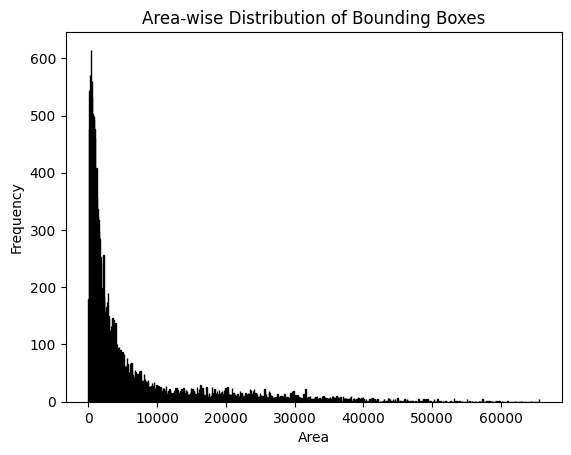

In [44]:
# Plotting the probability distribution
plt.hist(areas, bins=1000, edgecolor='black')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Area-wise Distribution of Bounding Boxes')
plt.show()

In [16]:
print(adj_train[1])

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [17]:
# Assuming X_train[0,:,0] and class_v[0] are numpy arrays
X_train_vector = X_train[0, :, 0]
class_v_vector = class_v[0]

In [123]:

def labels_from_class_and_part(X_train_vector,class_v_vector):
    # Broadcasting to match dimensions
    X_train_expanded = np.expand_dims(X_train_vector, axis=0)
    class_v_expanded = np.expand_dims(class_v_vector, axis=1)
    # Perform the dor product
    return np.dot(class_v_expanded,X_train_expanded)


In [124]:
def get_class_and_part_names(index_class_dict,class_comb_dict,index_part_list,X, class_v):
    x = np.where(class_v == 1)
    class_name = index_class_dict[int(x[0])]
    
    labels_v = labels_from_class_and_part(X[ :, 0], class_v)
    
    y = np.where(X[:, 0] == 1)
    
    all_part_names = []
    for i, t in enumerate(class_comb_dict[class_name]):
        #print(i,t)
        part_names = []
        if i in list(y[0]):
            for parts in class_comb_dict[class_name][t]:
                #print(parts)
                part_names.append(index_part_list[int(x[0])][parts])
                #print(index_part_list[int(x[0])][parts])
            #print("\n")
        if len(part_names)>0:
            all_part_names.append(part_names)
    return class_name, all_part_names , labels_v


In [125]:
len(labels_from_class_and_part(X_train_vector,class_v_vector))

7

In [126]:
#print(dense_to_sparse(torch.from_numpy(adj_train[2]).cuda().float()))


In [127]:
%cd ..
%cd ..
%cd LayoutDiffusion

C:\GitHub
C:\
[WinError 2] The system cannot find the file specified: 'LayoutDiffusion'
C:\


In [128]:
import os
import random
from collections import defaultdict
import torch
import torchvision.transforms as T
import numpy as np
import h5py
import PIL
import pickle
from layout_diffusion.dataset.util import image_normalize
from layout_diffusion.dataset.augmentations import RandomSampleCrop, RandomMirror
from torch.utils.data import Dataset
import json
from PIL import Image

In [129]:
from omegaconf import OmegaConf
from layout_diffusion.dataset.data_loader import build_loaders

In [130]:
#cfg = OmegaConf.load('./configs/COCO-stuff_256x256/LayoutDiffusion_large.yaml')
#print(cfg)

In [131]:
#train_loader = build_loaders(cfg, mode='train')

In [132]:
#for i,x in enumerate(train_loader):
#    print(x)
#    if (i == 3) :
#        break#

In [133]:
class MeronymnetDataset(Dataset):
    
    
    def __init__(self, images , X, class_v, index_class_dict, index_part_list, class_comb_dict, image_size=(256, 256),
                 max_objects_per_image=16, max_num_samples=None, mask_size=32,
                 use_orphaned_objects=True,  
                 left_right_flip=False, min_object_size=8, use_MinIoURandomCrop=False,
                 return_origin_image=False, specific_image_ids=[]
                 ):
        super(MeronymnetDataset, self).__init__()

        self.return_origin_image = return_origin_image
        if self.return_origin_image:
            self.origin_transform = T.Compose([
                T.ToTensor(),
                image_normalize()
            ])

        self.images = images
        self.X = X
        self.class_v = class_v
        self.index_class_dict = index_class_dict
        self.index_part_list = index_part_list
        self.class_comb_dict = class_comb_dict
        self.mask_size = mask_size
        self.image_size = image_size
        self.min_object_size = min_object_size
        # self.vocab = vocab
        self.num_objects = 112
        self.use_orphaned_objects = use_orphaned_objects
        self.max_objects_per_image = max_objects_per_image
        self.max_num_samples = max_num_samples
        self.left_right_flip = left_right_flip
        if left_right_flip:
            self.random_flip = RandomMirror()

        self.use_MinIoURandomCrop = use_MinIoURandomCrop
        if use_MinIoURandomCrop:
            self.MinIoURandomCrop = RandomSampleCrop()

        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize(size=image_size, antialias=True),
            image_normalize()
        ])

        self.total_num_bbox = 0
        self.total_num_invalid_bbox = 0
        
                     
        '''
        with h5py.File(h5_path, 'r') as f:
            for k, v in f.items():
                if k == 'image_paths':
                    # self.image_
                    self.image_paths = [str(path, encoding="utf-8") for path in list(v)]
                else:
                    self.data[k] = torch.IntTensor(np.asarray(v))
        
        '''
        
        self.data = {}
        self.data['images'] = []
        self.data['objects_per_image'] = []
        self.data['object_boxes'] =[]
        self.data['object_names'] =  []
        self.data['object_class']=[]
        for i in range(len(images)):
            #print(i)
            self.data['images'].append(images[i])
            self.data['object_boxes'].append(self.X[i,:,1:])
            class_name,all_part_names,labels_v = get_class_and_part_names(self.index_class_dict,self.class_comb_dict ,self.index_part_list ,self.X[i,:,:],class_v[i])
            object_names = []
            for i in range(len(all_part_names)):
                object_names.append(class_name+' '+' '.join(all_part_names[i]))
            self.data['object_names'].append(object_names)
            self.data['objects_per_image'].append(len(object_names))
            self.data['object_class'].append(np.where(labels_v==1)[0]+1) # 1 to 112 
            
            #self.data['relationship_subjects'] = 

        '''
        self.vocab = {
            'object_name_to_idx': {},
            'pred_name_to_idx': {},
        }
        object_idx_to_name = {}
        all_instance_categories = []
        for category_data in instances_data['categories']:
            category_id = category_data['id']
            category_name = category_data['name']
            all_instance_categories.append(category_name)
            object_idx_to_name[category_id] = category_name
            self.vocab['object_name_to_idx'][category_name] = category_id
        all_stuff_categories = []
        if stuff_data:
            for category_data in stuff_data['categories']:
                category_name = category_data['name']
                category_id = category_data['id']
                all_stuff_categories.append(category_name)
                object_idx_to_name[category_id] = category_name
                self.vocab['object_name_to_idx'][category_name] = category_id

        '''            
        # get specific image ids or get specific number of images
        selected_idx = []
        self.specific_image_ids = specific_image_ids
        if self.specific_image_ids:
            specific_image_ids_set = set(specific_image_ids)
            for idx, image_path in enumerate(self.image_paths):
                if image_path in specific_image_ids_set:
                    selected_idx.append(idx)
                    specific_image_ids_set.remove(image_path)
                if len(specific_image_ids_set) == 0:
                    break

            if len(specific_image_ids_set) > 0:
                for image_path in list(specific_image_ids_set):
                    print('image path: {} is not found'.format(image_path))

            assert len(specific_image_ids_set) == 0
        elif self.max_num_samples:
            selected_idx = [idx for idx in range(self.max_num_samples)]

        if selected_idx:
            print('selected_idx = {}'.format(selected_idx))
            self.image_paths = [self.image_paths[idx] for idx in selected_idx]
            for k in list(self.data.keys()):
                self.data[k] = self.data[k][selected_idx]

    def check_with_relation(self, image_index):
        '''
        :param obj_idxs: the idxs of objects of image
        :return: with_relations = [True, False, ....], shape=(O,), O is the number of objects
        '''
        obj_idxs = range(self.data['objects_per_image'][image_index].item())
        with_relations = [False for i in obj_idxs]
        for r_idx in range(self.data['relationships_per_image'][image_index]):
            s = self.data['relationship_subjects'][image_index, r_idx].item()
            o = self.data['relationship_objects'][image_index, r_idx].item()
            with_relations[s] = True
            with_relations[o] = True
        without_relations = [not i for i in with_relations]
        return with_relations, without_relations

    def filter_invalid_bbox(self, H, W, bbox, is_valid_bbox, verbose=False):

        for idx, obj_bbox in enumerate(bbox):
            if not is_valid_bbox[idx]:
                continue
            self.total_num_bbox += 1

            x, y, w, h = obj_bbox

            if (x >= W) or (y >= H):
                is_valid_bbox[idx] = False
                self.total_num_invalid_bbox += 1
                if verbose:
                    print(
                        'total_num = {}, invalid_num = {}, x = {}, y={}, w={}, h={}, W={}, H={}'.format(
                            self.total_num_bbox, self.total_num_invalid_bbox, x, y, w, h, W, H,
                        )
                    )
                continue

            x0, y0, x1, y1 = x, y, x + w, y + h
            x1 = np.clip(x + w, 1, W)
            y1 = np.clip(y + h, 1, H)

            if (y1 - y0 < self.min_object_size) or (x1 - x0 < self.min_object_size):
                is_valid_bbox[idx] = False
                self.total_num_invalid_bbox += 1
                if verbose:
                    print(
                        'total_num = {}, invalid_num = {}, x = {}, y={}, w={}, h={}, W={}, H={}'.format(
                            self.total_num_bbox, self.total_num_invalid_bbox, x, y, w, h, W, H,
                        )
                    )
                continue
            bbox[idx][0], bbox[idx][1], bbox[idx][2], bbox[idx][3] = x0, y0, x1, y1

        return bbox, is_valid_bbox

    def get_init_meta_data(self, image_index):
        layout_length = self.max_objects_per_image + 2
        meta_data = {
            'obj_bbox': torch.zeros([layout_length, 4]),
            'obj_class': torch.LongTensor(layout_length).fill_(self.num_objects + 1),
            'obj_class_name':['_null_'*layout_length],
            'is_valid_obj': torch.zeros([layout_length]),
        }

        # The first object will be the special __image__ object
        meta_data['obj_bbox'][0] = torch.FloatTensor([0, 0, 1, 1])
        meta_data['obj_class'][0] = 0
        meta_data['is_valid_obj'][0] = 1.0

        return meta_data

    def __len__(self):
        num = len(self.data['object_names'])
        assert num == len(self.data['object_class'])
        return num

    def __getitem__(self, index):
        """
        Returns a tuple of:
        - image: FloatTensor of shape (C, H, W)
        - objs: LongTensor of shape (O,)
        - boxes: FloatTensor of shape (O, 4) giving boxes for objects in
          (x0, y0, x1, y1) format, in a [0, 1] coordinate system.
        """

        # Figure out which objects appear in relationships and which don't
        # with_relations, without_relations = self.check_with_relation(image_index=index)  # (O,)

        image = self.data['images'][index]
        if self.return_origin_image:
            origin_image = np.array(image, dtype=np.float32) / 255.0
        
        image = np.array(image, dtype=np.float32) / 255.0
        H, W, _ = image.shape
        num_obj = self.data['objects_per_image'][index]
        obj_bbox = self.data['object_boxes'][index][:num_obj]
        obj_class = self.data['object_class'][index][:num_obj]
        obj_class_name = self.data['object_names'][index][:num_obj]
        is_valid_obj = (obj_class >= 0)
        
        # get meta data
        meta_data = self.get_init_meta_data(image_index=index)
        meta_data['width'], meta_data['height'] = W, H
        #meta_data['with_relations'] = with_relations

        # filter invalid bbox
        obj_bbox, is_valid_obj = self.filter_invalid_bbox(H=H, W=W, bbox=obj_bbox, is_valid_bbox=is_valid_obj)

        # flip
        if self.left_right_flip:
            image, obj_bbox, obj_class = self.random_flip(image, obj_bbox, obj_class)

        # random crop image and its bbox
        if self.use_MinIoURandomCrop:
            image, updated_obj_bbox, updated_obj_class, tmp_is_valid_obj = self.MinIoURandomCrop(image, obj_bbox[is_valid_obj], obj_class[is_valid_obj])

            tmp_idx = 0
            tmp_tmp_idx = 0
            for idx, is_valid in enumerate(is_valid_obj):
                if is_valid:
                    if tmp_is_valid_obj[tmp_idx]:
                        obj_bbox[idx] = updated_obj_bbox[tmp_tmp_idx]
                        tmp_tmp_idx += 1
                    else:
                        is_valid_obj[idx] = False
                    tmp_idx += 1

            meta_data['new_height'] = image.shape[0]
            meta_data['new_width'] = image.shape[1]
            H, W, _ = image.shape

        obj_bbox = torch.FloatTensor(obj_bbox[is_valid_obj])
        obj_class = torch.LongTensor(obj_class[is_valid_obj])

        obj_bbox[:, 0::2] = obj_bbox[:, 0::2] / W
        obj_bbox[:, 1::2] = obj_bbox[:, 1::2] / H


        num_selected = min(obj_bbox.shape[0], self.max_objects_per_image)
        selected_obj_idxs = random.sample(range(obj_bbox.shape[0]), num_selected)
        meta_data['obj_bbox'][1:1 + num_selected] = obj_bbox[selected_obj_idxs]
        meta_data['obj_class'][1:1 + num_selected] = obj_class[selected_obj_idxs]
        meta_data['is_valid_obj'][1:1 + num_selected] = 1.0
        meta_data['num_selected'] = num_selected
        meta_data['num_add'] = 0
        meta_data['obj_class_name'][1:1+num_selected] = obj_class_name
        meta_data['num_obj'] = meta_data['num_selected'] + meta_data['num_add'] - 1

        if self.return_origin_image:
            meta_data['origin_image'] = self.origin_transform(origin_image)

        return self.transform(image), meta_data

'''
        if num_selected < self.max_objects_per_image and self.use_orphaned_objects:
            num_add = min(self.max_objects_per_image - num_selected, obj_bbox_without_relations.shape[0])
            if num_add > 0:
                selected_obj_idxs = random.sample(range(obj_bbox_without_relations.shape[0]), num_add)
                meta_data['obj_bbox'][1 + num_selected:1 + num_selected + num_add] = obj_bbox_without_relations[selected_obj_idxs]
                meta_data['obj_class'][1 + num_selected:1 + num_selected + num_add] = obj_class_without_relations[selected_obj_idxs]
                meta_data['is_valid_obj'][1 + num_selected:1 + num_selected + num_add] = 1.0
                meta_data['num_add'] = num_add
'''
def mn_collate_fn_for_layout(batch):
    """
    Collate function to be used when wrapping CocoSceneGraphDataset in a
    DataLoader. Returns a tuple of the following:

    - imgs: FloatTensor of shape (N, C, H, W)
    - objs: LongTensor of shape (N, L) giving object categories
    - masks: FloatTensor of shape (N, L, H, W)
    - is_valid_obj: FloatTensor of shape (N, L)
    """

    all_meta_data = defaultdict(list)
    all_imgs = []

    for i, (img, meta_data) in enumerate(batch):
        all_imgs.append(img[None])
        for key, value in meta_data.items():
            all_meta_data[key].append(value)

    all_imgs = torch.cat(all_imgs)
    for key, value in all_meta_data.items():
        if key in ['obj_bbox', 'obj_class', 'is_valid_obj'] or key.startswith('labels_from_layout_to_image_at_resolution'):
            all_meta_data[key] = torch.stack(value)

    return all_imgs, all_meta_data




def load_data(mode):
    data_path = 'C:/GitHub/meronymnet/data_np_16/'
    part_data_post_fix = '_scaled_sqr'
    obj_data_postfix = '_obj_boundary_sqr'
    file_postfix = '_combined_mask_data'

    if mode == 'train':
        X_file = 'X_train' + part_data_post_fix + '.np'
        class_v_file = 'class_v' + file_postfix + '.np'
        images_file = 'images_train' + file_postfix + '.np'
    elif mode == 'val':
        X_file = 'X_train_val' + part_data_post_fix + '.np'
        class_v_file = 'class_v_val' + file_postfix + '.np'
        images_file = 'images_val' + file_postfix + '.np'
    elif mode == 'test':
        X_file = 'X_test' + part_data_post_fix + '.np'
        class_v_file = 'class_v_test' + file_postfix + '.np'
        images_file = 'images_test' + file_postfix + '.np'
    else:
        raise ValueError("Invalid mode. Mode should be 'train', 'val', or 'test'.")

    with open(data_path + X_file, 'rb') as pickle_file:
        X = pickle.load(pickle_file)

    with open(data_path + class_v_file, 'rb') as pickle_file:
        class_v = pickle.load(pickle_file)

    with open(data_path + images_file, 'rb') as pickle_file:
        images = pickle.load(pickle_file)

    return X, class_v, images


def build_mn_dsets(cfg, mode='train'):
    assert mode in ['train', 'val', 'test']
    X,class_v,images = load_data(mode)
    
    params = cfg.data.parameters
    
    '''with open(os.path.join(params.root_dir, params.vocab_json), 'r') as f:
        vocab = json.load(f)
    '''
    #object_names = ['bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'person']

    #part labels
    bird_labels = {'head':1, 'leye':2, 'reye':3, 'beak':4, 'torso':5, 'neck':6, 'lwing':7, 'rwing':8, 'lleg':9, 'lfoot':10, 'rleg':11, 'rfoot':12, 'tail':13}

    cat_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17}

    cow_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lhorn':7, 'rhorn':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19}

    dog_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17, 'muzzle':18}

    horse_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lfho':7, 'rfho':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19, 'lbho':20, 'rbho':21}
    
    sheep_labels = cow_labels

    person_labels = {'head':1, 'leye':2,  'reye':3, 'lear':4, 'rear':5, 'lebrow':6, 'rebrow':7,  'nose':8,  'mouth':9,  'hair':10, 'torso':11, 'neck': 12, 'llarm': 13, 'luarm': 14, 'lhand': 15, 'rlarm':16, 'ruarm':17, 'rhand': 18, 'llleg': 19, 'luleg':20, 'lfoot':21, 'rlleg':22, 'ruleg':23, 'rfoot':24}
    
    part_dict = {
        'bird' : bird_labels,
        'cat' : cat_labels,
        'cow' : cow_labels,
        'dog' : dog_labels,
        'horse' : horse_labels,
        'sheep' : sheep_labels,
        'person' : person_labels
    }
    bird_comb = {
        1 : [1, 2, 3, 4],
        5 : [5],
        6 : [6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13]
    }

    cat_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17]
    }
    cow_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19]
    }
    dog_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18]
    }
    horse_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19],
        20 : [20],
        21 : [21]
    }
    sheep_comb = {
        1 : [1, 2, 3, 4, 5, 6],
        7 : [7],
        8 : [8],
        9 : [9],
        10 : [10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19]
    }
    person_comb = {
        1 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        11 : [11],
        12 : [12],
        13 : [13],
        14 : [14],
        15 : [15],
        16 : [16],
        17 : [17],
        18 : [18],
        19 : [19],
        20 : [20],
        21 : [21],
        22 : [22],
        23 : [23],
        24 : [24],
    }


    class_comb_dict = {
        'bird' : bird_comb,
        'cat' : cat_comb,
        'cow' : cow_comb,
        'dog' : dog_comb,
        'horse' : horse_comb,
        'sheep' : sheep_comb,
        'person' : person_comb
    
    }
    labels_v = []
    index_class_dict = {index: name for index, name in enumerate(class_comb_dict)}
    part_dict_list  = [ part_dict[name] for index, name in enumerate(part_dict)]
    index_part_list = []
    for i,part_dict in enumerate(part_dict_list):
        index_part_list.append({index+1: name for index, name in enumerate(part_dict)})
            
    #print(vocab)
    #vocab['object_name_to_idx']['__image__'] = 0
    #vocab['object_name_to_idx']['__null__'] = 179
    #vocab['object_idx_to_name'].append('__null__')

    dataset = MeronymnetDataset(
        images = images,
        X = X,
        class_v = class_v,
        index_class_dict=index_class_dict,
        index_part_list=index_part_list,
        class_comb_dict=class_comb_dict,
        image_size=(params.image_size, params.image_size),
        mask_size=params.mask_size_for_layout_object,
        max_num_samples=params[mode].max_num_samples,
        max_objects_per_image=params.max_objects_per_image,
        left_right_flip=params[mode].left_right_flip,
        use_orphaned_objects=params.use_orphaned_objects,
        use_MinIoURandomCrop=params[mode].use_MinIoURandomCrop,
        return_origin_image=params.return_origin_image,
        specific_image_ids=params[mode].specific_image_ids
    )

    num_imgs = len(dataset)
    print('%s dataset has %d images' % (mode, num_imgs))

    return dataset


In [134]:
cd \GitHub\LayoutDiffusion

C:\GitHub\LayoutDiffusion


In [112]:
cfg = OmegaConf.load('./configs/MN_256x256/LayoutDiffusion_large.yaml')
#print(cfg)
train_loader = build_mn_dsets(cfg, mode='train')

train dataset has 3394 images


In [113]:
for i, X in enumerate(train_loader):
    x ,meta_data = X
    print(meta_data)
    print("\n\n")
    print(x)
    if i == 0:
        break

{'obj_bbox': tensor([[0., 0., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), 'obj_class': tensor([  0, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113,
        113, 113, 113, 113]), 'obj_class_name': ['_null__null__null__null__null__null__null__null__null__null__null__null__null__null__null__null__null__null_', 'cow head leye reye lear rear muzzle', 'cow lhorn', 'cow rhorn', 'cow lfuleg', 'cow rfuleg', 'cow lbuleg'], 'is_valid_obj': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'width': 256, 'height': 256, 'num_selected': 0, 'num_add': 

In [114]:
#part labels
bird_labels = {'head':1, 'leye':2, 'reye':3, 'beak':4, 'torso':5, 'neck':6, 'lwing':7, 'rwing':8, 'lleg':9, 'lfoot':10, 'rleg':11, 'rfoot':12, 'tail':13}

cat_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17}

cow_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lhorn':7, 'rhorn':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19}

dog_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'nose':6, 'torso':7, 'neck':8, 'lfleg':9, 'lfpa':10, 'rfleg':11, 'rfpa':12, 'lbleg':13, 'lbpa':14, 'rbleg':15, 'rbpa':16, 'tail':17, 'muzzle':18}

horse_labels = {'head':1, 'leye':2, 'reye':3, 'lear':4, 'rear':5, 'muzzle':6, 'lfho':7, 'rfho':8, 'torso':9, 'neck':10, 'lfuleg':11, 'lflleg':12, 'rfuleg':13, 'rflleg':14, 'lbuleg':15, 'lblleg':16, 'rbuleg':17, 'rblleg':18, 'tail':19, 'lbho':20, 'rbho':21}

sheep_labels = cow_labels

person_labels = {'head':1, 'leye':2,  'reye':3, 'lear':4, 'rear':5, 'lebrow':6, 'rebrow':7,  'nose':8,  'mouth':9,  'hair':10, 'torso':11, 'neck': 12, 'llarm': 13, 'luarm': 14, 'lhand': 15, 'rlarm':16, 'ruarm':17, 'rhand': 18, 'llleg': 19, 'luleg':20, 'lfoot':21, 'rlleg':22, 'ruleg':23, 'rfoot':24}


In [115]:
part_dict = {
    'bird' : bird_labels,
    'cat' : cat_labels,
    'cow' : cow_labels,
    'dog' : dog_labels,
    'horse' : horse_labels,
    'sheep' : sheep_labels,
    'person' : person_labels
}

In [116]:
bird_comb = {
    1 : [1, 2, 3, 4],
    5 : [5],
    6 : [6],
    7 : [7],
    8 : [8],
    9 : [9],
    10 : [10],
    11 : [11],
    12 : [12],
    13 : [13]
}

cat_comb = {
    1 : [1, 2, 3, 4, 5, 6],
    7 : [7],
    8 : [8],
    9 : [9],
    10 : [10],
    11 : [11],
    12 : [12],
    13 : [13],
    14 : [14],
    15 : [15],
    16 : [16],
    17 : [17]
}
cow_comb = {
    1 : [1, 2, 3, 4, 5, 6],
    7 : [7],
    8 : [8],
    9 : [9],
    10 : [10],
    11 : [11],
    12 : [12],
    13 : [13],
    14 : [14],
    15 : [15],
    16 : [16],
    17 : [17],
    18 : [18],
    19 : [19]
}
dog_comb = {
    1 : [1, 2, 3, 4, 5, 6],
    7 : [7],
    8 : [8],
    9 : [9],
    10 : [10],
    11 : [11],
    12 : [12],
    13 : [13],
    14 : [14],
    15 : [15],
    16 : [16],
    17 : [17],
    18 : [18]
}
horse_comb = {
    1 : [1, 2, 3, 4, 5, 6],
    7 : [7],
    8 : [8],
    9 : [9],
    10 : [10],
    11 : [11],
    12 : [12],
    13 : [13],
    14 : [14],
    15 : [15],
    16 : [16],
    17 : [17],
    18 : [18],
    19 : [19],
    20 : [20],
    21 : [21]
}
sheep_comb = {
    1 : [1, 2, 3, 4, 5, 6],
    7 : [7],
    8 : [8],
    9 : [9],
    10 : [10],
    11 : [11],
    12 : [12],
    13 : [13],
    14 : [14],
    15 : [15],
    16 : [16],
    17 : [17],
    18 : [18],
    19 : [19]
}
person_comb = {
    1 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    11 : [11],
    12 : [12],
    13 : [13],
    14 : [14],
    15 : [15],
    16 : [16],
    17 : [17],
    18 : [18],
    19 : [19],
    20 : [20],
    21 : [21],
    22 : [22],
    23 : [23],
    24 : [24],
}


class_comb_dict = {
    'bird' : bird_comb,
    'cat' : cat_comb,
    'cow' : cow_comb,
    'dog' : dog_comb,
    'horse' : horse_comb,
    'sheep' : sheep_comb,
    'person' : person_comb
    
}



In [36]:
labels_v = []
index_class_dict = {index: name for index, name in enumerate(class_comb_dict)}
#part_dict= {}
part_dict_list  = [ part_dict[name] for index, name in enumerate(part_dict)]
print(part_dict_list)
index_part_list = []
for i,part_dict in enumerate(part_dict_list):
    index_part_list.append({index+1: name for index, name in enumerate(part_dict)})
#print(index_part_list)
 

[{'head': 1, 'leye': 2, 'reye': 3, 'beak': 4, 'torso': 5, 'neck': 6, 'lwing': 7, 'rwing': 8, 'lleg': 9, 'lfoot': 10, 'rleg': 11, 'rfoot': 12, 'tail': 13}, {'head': 1, 'leye': 2, 'reye': 3, 'lear': 4, 'rear': 5, 'nose': 6, 'torso': 7, 'neck': 8, 'lfleg': 9, 'lfpa': 10, 'rfleg': 11, 'rfpa': 12, 'lbleg': 13, 'lbpa': 14, 'rbleg': 15, 'rbpa': 16, 'tail': 17}, {'head': 1, 'leye': 2, 'reye': 3, 'lear': 4, 'rear': 5, 'muzzle': 6, 'lhorn': 7, 'rhorn': 8, 'torso': 9, 'neck': 10, 'lfuleg': 11, 'lflleg': 12, 'rfuleg': 13, 'rflleg': 14, 'lbuleg': 15, 'lblleg': 16, 'rbuleg': 17, 'rblleg': 18, 'tail': 19}, {'head': 1, 'leye': 2, 'reye': 3, 'lear': 4, 'rear': 5, 'nose': 6, 'torso': 7, 'neck': 8, 'lfleg': 9, 'lfpa': 10, 'rfleg': 11, 'rfpa': 12, 'lbleg': 13, 'lbpa': 14, 'rbleg': 15, 'rbpa': 16, 'tail': 17, 'muzzle': 18}, {'head': 1, 'leye': 2, 'reye': 3, 'lear': 4, 'rear': 5, 'muzzle': 6, 'lfho': 7, 'rfho': 8, 'torso': 9, 'neck': 10, 'lfuleg': 11, 'lflleg': 12, 'rfuleg': 13, 'rflleg': 14, 'lbuleg': 15, 

In [37]:
#print(index_class_dict)
print(index_part_list)
#print(class_comb_dict)


[{1: 'head', 2: 'leye', 3: 'reye', 4: 'beak', 5: 'torso', 6: 'neck', 7: 'lwing', 8: 'rwing', 9: 'lleg', 10: 'lfoot', 11: 'rleg', 12: 'rfoot', 13: 'tail'}, {1: 'head', 2: 'leye', 3: 'reye', 4: 'lear', 5: 'rear', 6: 'nose', 7: 'torso', 8: 'neck', 9: 'lfleg', 10: 'lfpa', 11: 'rfleg', 12: 'rfpa', 13: 'lbleg', 14: 'lbpa', 15: 'rbleg', 16: 'rbpa', 17: 'tail'}, {1: 'head', 2: 'leye', 3: 'reye', 4: 'lear', 5: 'rear', 6: 'muzzle', 7: 'lhorn', 8: 'rhorn', 9: 'torso', 10: 'neck', 11: 'lfuleg', 12: 'lflleg', 13: 'rfuleg', 14: 'rflleg', 15: 'lbuleg', 16: 'lblleg', 17: 'rbuleg', 18: 'rblleg', 19: 'tail'}, {1: 'head', 2: 'leye', 3: 'reye', 4: 'lear', 5: 'rear', 6: 'nose', 7: 'torso', 8: 'neck', 9: 'lfleg', 10: 'lfpa', 11: 'rfleg', 12: 'rfpa', 13: 'lbleg', 14: 'lbpa', 15: 'rbleg', 16: 'rbpa', 17: 'tail', 18: 'muzzle'}, {1: 'head', 2: 'leye', 3: 'reye', 4: 'lear', 5: 'rear', 6: 'muzzle', 7: 'lfho', 8: 'rfho', 9: 'torso', 10: 'neck', 11: 'lfuleg', 12: 'lflleg', 13: 'rfuleg', 14: 'rflleg', 15: 'lbuleg', 

In [135]:
lables_v=labels_from_class_and_part(X_train[0,:,0],class_v[0])
print(labels_v)
print(class_v[0])

[0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]


In [118]:
def filtered_labels(labels_v,class_v,class_comb_dict):
    label = []
    for i, x in enumerate(enumerate(class_comb_dict.values())):
        (j,t)=x 
        label.append(labels_v[i,:len(t.keys())])
    print(len(label))

In [119]:
filtered_labels(labels_v,class_v[0],class_comb_dict)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [38]:
def get_class_and_part_names(X, class_v):
    x = np.where(class_v == 1)
    class_name = index_class_dict[int(x[0])]
    
    labels_v = labels_from_class_and_part(X[ :, 0], class_v)
    
    y = np.where(X[:, 0] == 1)
    
    all_part_names = []
    for i, t in enumerate(class_comb_dict[class_name]):
        #print(i,t)
        part_names = []
        if i in list(y[0]):
            for parts in class_comb_dict[class_name][t]:
                print(class_name)
                print(parts)
                print(index_part_list[int(x[0])])
                part_names.append(index_part_list[int(x[0])][parts])
                #print(index_part_list[int(x[0])][parts])
            #print("\n")
        if len(part_names)>0:
            all_part_names.append(part_names)
    return class_name, all_part_names , labels_v


In [45]:
class_name , all_part_names , labels_v = get_class_and_part_names(X_train[1206], class_v[1206])

bird
7
{1: 'head', 2: 'leye', 3: 'reye', 4: 'beak', 5: 'torso', 6: 'neck', 7: 'lwing', 8: 'rwing', 9: 'lleg', 10: 'lfoot', 11: 'rleg', 12: 'rfoot', 13: 'tail'}
bird
9
{1: 'head', 2: 'leye', 3: 'reye', 4: 'beak', 5: 'torso', 6: 'neck', 7: 'lwing', 8: 'rwing', 9: 'lleg', 10: 'lfoot', 11: 'rleg', 12: 'rfoot', 13: 'tail'}
bird
10
{1: 'head', 2: 'leye', 3: 'reye', 4: 'beak', 5: 'torso', 6: 'neck', 7: 'lwing', 8: 'rwing', 9: 'lleg', 10: 'lfoot', 11: 'rleg', 12: 'rfoot', 13: 'tail'}
bird
13
{1: 'head', 2: 'leye', 3: 'reye', 4: 'beak', 5: 'torso', 6: 'neck', 7: 'lwing', 8: 'rwing', 9: 'lleg', 10: 'lfoot', 11: 'rleg', 12: 'rfoot', 13: 'tail'}


In [ ]:
print(labels_v)

In [ ]:
print(all_part_names)

In [ ]:
for i in range(len(all_part_names)):
    print(class_name+' '+' '.join(all_part_names[i]))

In [ ]:
print(list(np.where(labels_v==1.0)[0]))

In [ ]:
for i in range(len(X_train)):
    x = np.where(class_v[i] == 1)
    class_name = index_class_dict[int(x[0])]
    #print(class_name)
    #print(int(x[0]),"\n")
    labels_v.append(labels_from_class_and_part(X_train[i,:,0],class_v[i]))
    y = np.where(X_train[i,:,0]==1)
    #print(list(y[0]))
    part_names = []
    for index, t in enumerate(class_comb_dict[class_name]):
        if (index in list(y[0])):
            #print(class_comb_dict[class_name][t])
            for parts in class_comb_dict[class_name][t]:
                part_names.append(index_part_list[int(x[0])][parts])
                
    print(part_names)
        #print(j)
    if(i ==3):
        break
    print("\n")  